In [1]:
import os
os.chdir('..')

In [89]:
import torch
from torch import nn
import torch.nn.functional as F
from collections import OrderedDict
import numpy as np
from torch.nn import init
import itertools
from src.model import *
from src.dataset import *
from tqdm import tqdm
import pickle
import random
from itertools import combinations
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import rbf_kernel, cosine_similarity
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt

In [5]:
device = 'cuda'

## Register hook

In [94]:
##### HELPER FUNCTION FOR FEATURE EXTRACTION
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

In [95]:
# model = BaseModel()
# model.load_state_dict(torch.load('./checkpoints/CIFAR17_add000000-CIFAR10-model1/199.pt'))

model = ChildModel(extra_filter = [0, 0, 0])
model.load_state_dict(torch.load('./checkpoints/CIFAR17_add000000-CIFAR10-model1/199.pt'))

model.body.cnn1.register_forward_hook(get_features('cnn1'))
model.body.cnn2.register_forward_hook(get_features('cnn2'))
model.body.cnn3.register_forward_hook(get_features('cnn3'))

model.head.dense.fc1.register_forward_hook(get_features('fc1'))
model.head.dense.fc2.register_forward_hook(get_features('fc2'))

model.to(device)

ChildModel(
  (body): Sequential(
    (cnn1): Sequential(
      (conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (cnn2): Sequential(
      (conv): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (cnn3): Sequential(
      (conv): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (head): Sequential(
    (dense): Sequential(
      (fc1): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1))
      (relu): ReLU(inplace=True)
      (fc2): Conv2d(32, 10, kernel_size=(1, 1), stride=(1, 1))
    )
  )
)

In [ ]:
# # test on random tensor
# x = torch.randn((1, 3, 32, 32))

# # placeholder for batch features
# features = {}
# output = model(x)

# features['fc1']

## Get intermediate representation for all training data

In [7]:
train_data_loader = data_loader(dataset_name = 'CIFAR10', 
                                batch_size = 128, 
                                train=True)

Files already downloaded and verified


In [14]:
# Total training is 50K, too many, downsample 10K, run only ONCE
random.seed(1234)
subsample_id = random.sample(range(len(train_data_loader.dataset)), 10000)

np.save('subsample_train', subsample_id)

In [96]:
# Directly load the pre-computed subsampled data
subsample_id = np.load('subsample_train.npy')

subtrain_data_loader = data_loader(dataset_name = 'CIFAR10', 
                                batch_size = 128, 
                                train=True,
                                subsample_id=subsample_id)

Files already downloaded and verified


In [100]:
##### FEATURE EXTRACTION LOOP

# placeholders
LABELS = []
FEATS = {}
INPUTS = torch.tensor([])

# loop through batches
for inputs, targets in tqdm(subtrain_data_loader):

    # move to device
    inputs = inputs.to(device)
    INPUTS = torch.cat((INPUTS, inputs.detach().cpu()), dim=0)
    
    # placeholder for batch features
    features = {}
       
    # forward pass [with feature extraction]
    preds = model(inputs)
    
    # add labels to list
    LABELS.extend(targets.numpy())
    
    # add feats to lists
    for k in features.keys():
        if k not in FEATS.keys():
            FEATS[k] = features[k].cpu().numpy()
        else:
            FEATS[k] = np.concatenate((FEATS[k], features[k].cpu().numpy()), axis=0)
            
LABELS = np.asarray(LABELS)

100%|██████████| 79/79 [00:05<00:00, 15.16it/s]


In [80]:
with open('checkpoints/CIFAR17_add010005-CIFAR10-model1/feat_representation.pkl', 'wb') as handle:
    pickle.dump(FEATS, handle)

with open('checkpoints/CIFAR17_add010005-CIFAR10-model1/label.pkl', 'wb') as handle:
    pickle.dump(LABELS, handle)

In [101]:
INPUTS.shape

torch.Size([10000, 3, 32, 32])

## Visualize feature maps

In [87]:
with open('checkpoints/CIFAR17_add000000-CIFAR10-model1/feat_representation.pkl', 'rb') as handle:
    FEATS = pickle.load(handle)

with open('checkpoints/CIFAR17_add000000-CIFAR10-model1/label.pkl', 'rb') as handle:
    LABELS = pickle.load(handle)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


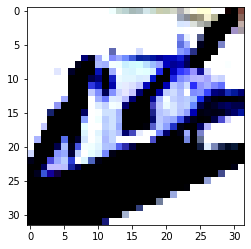

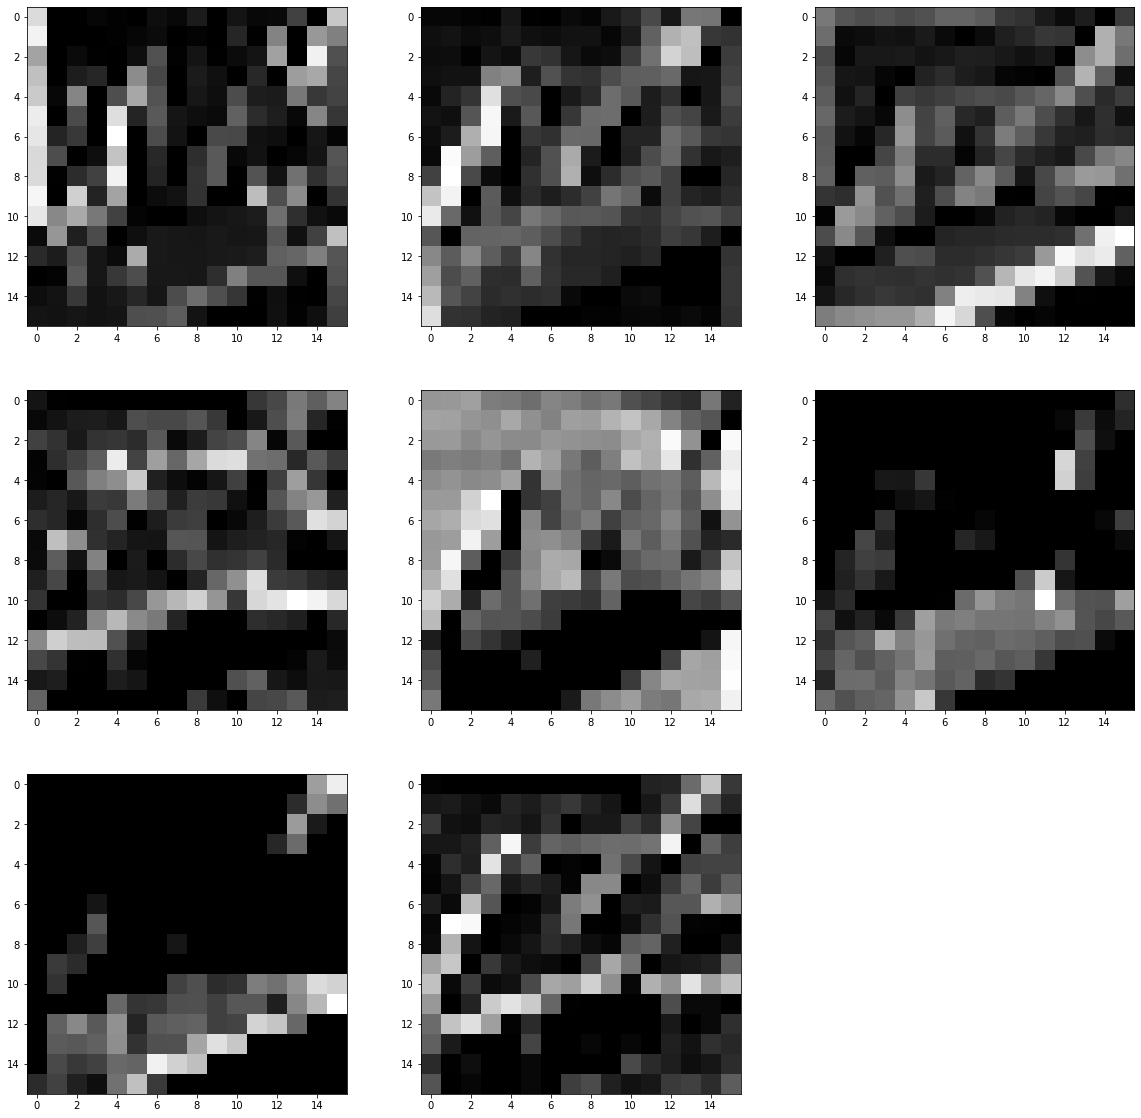

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


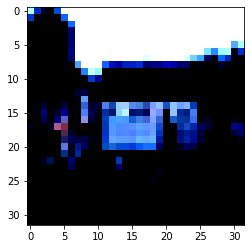

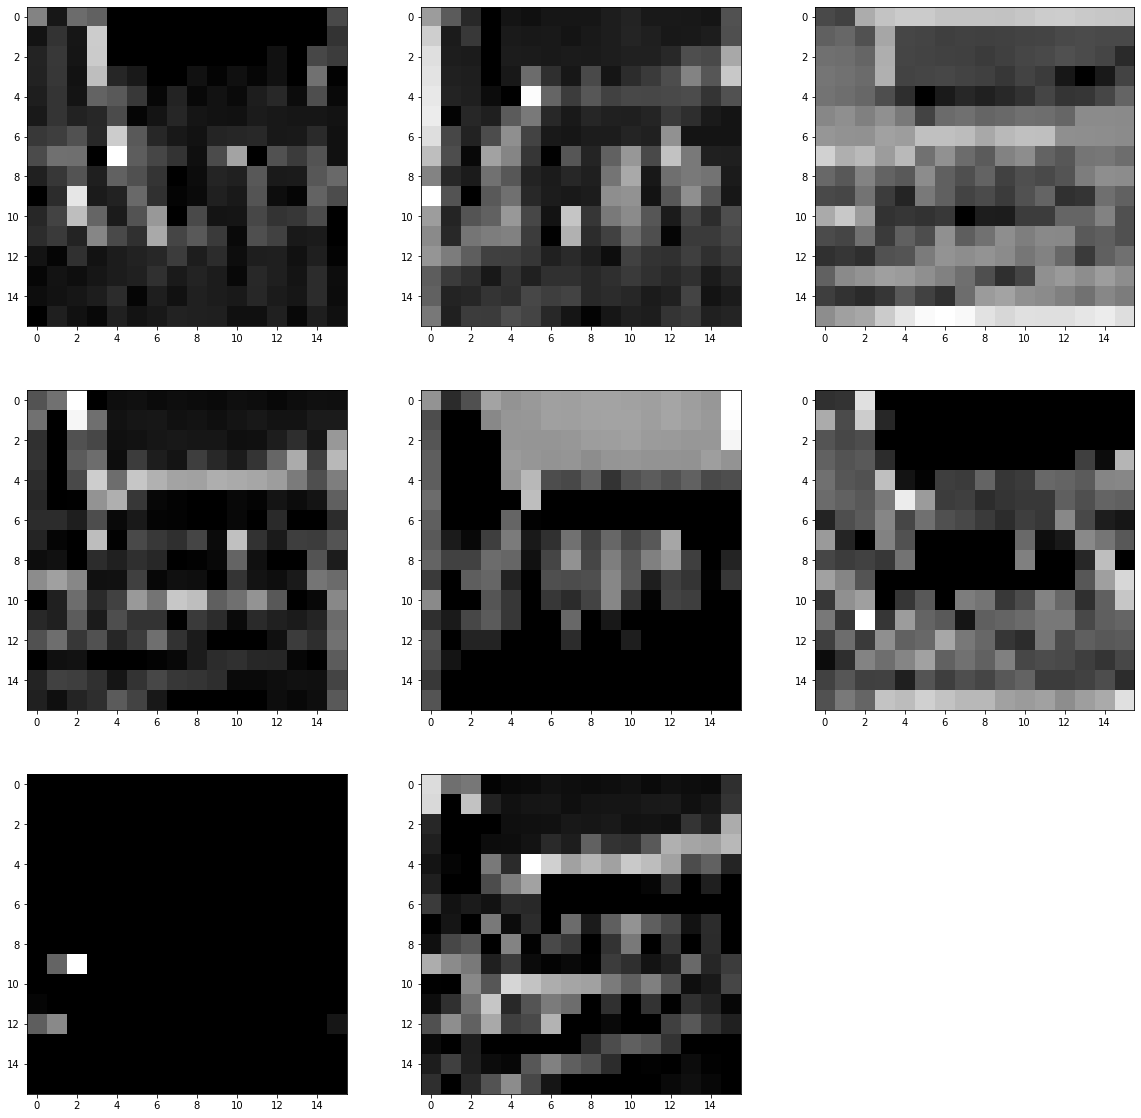

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


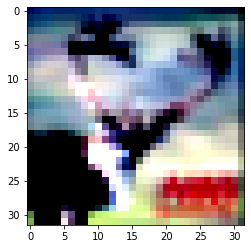

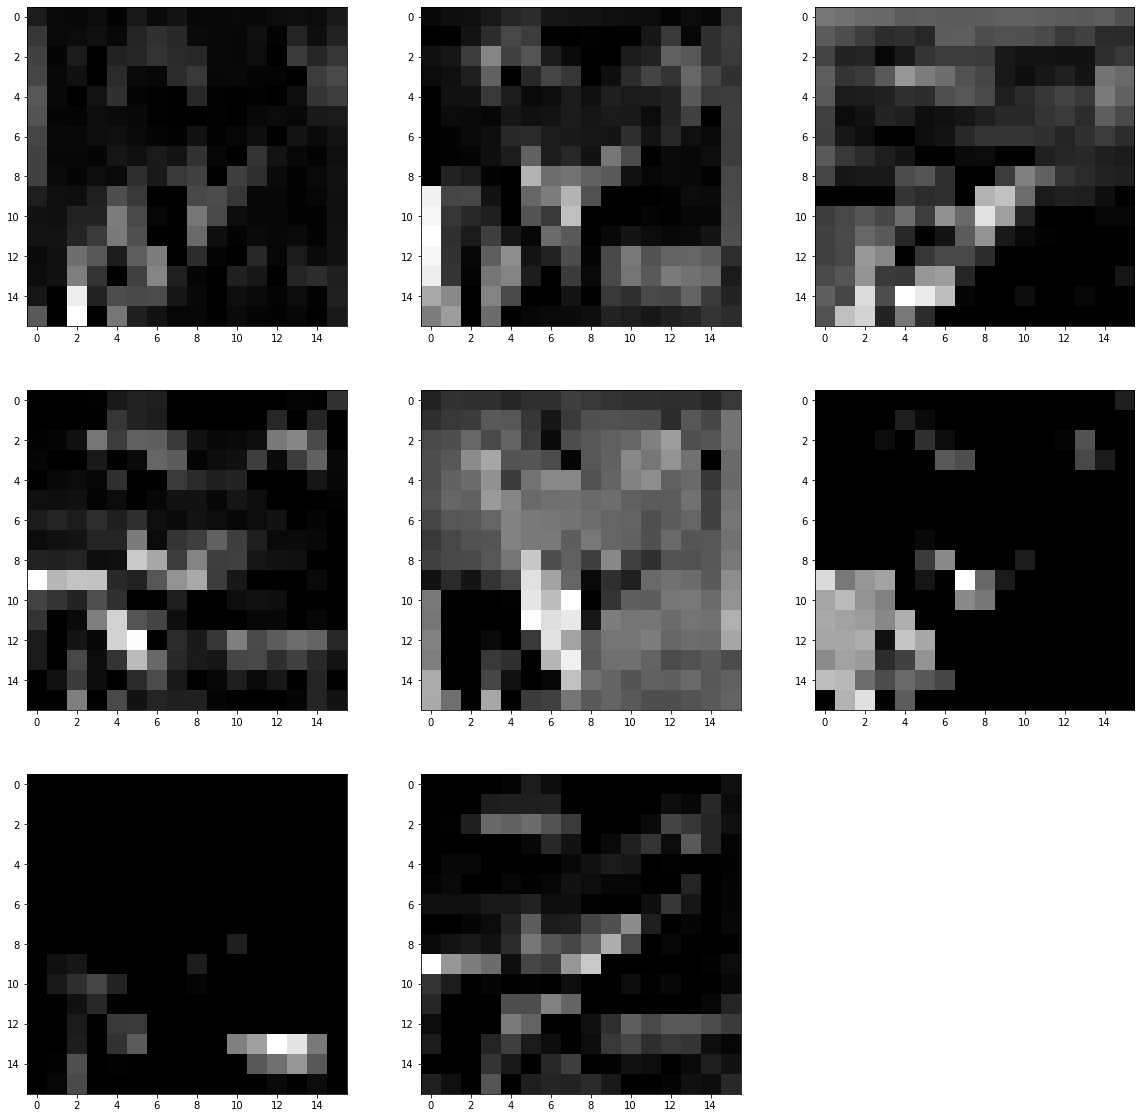

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


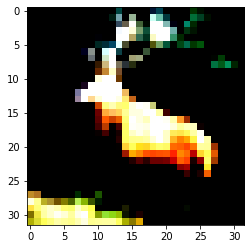

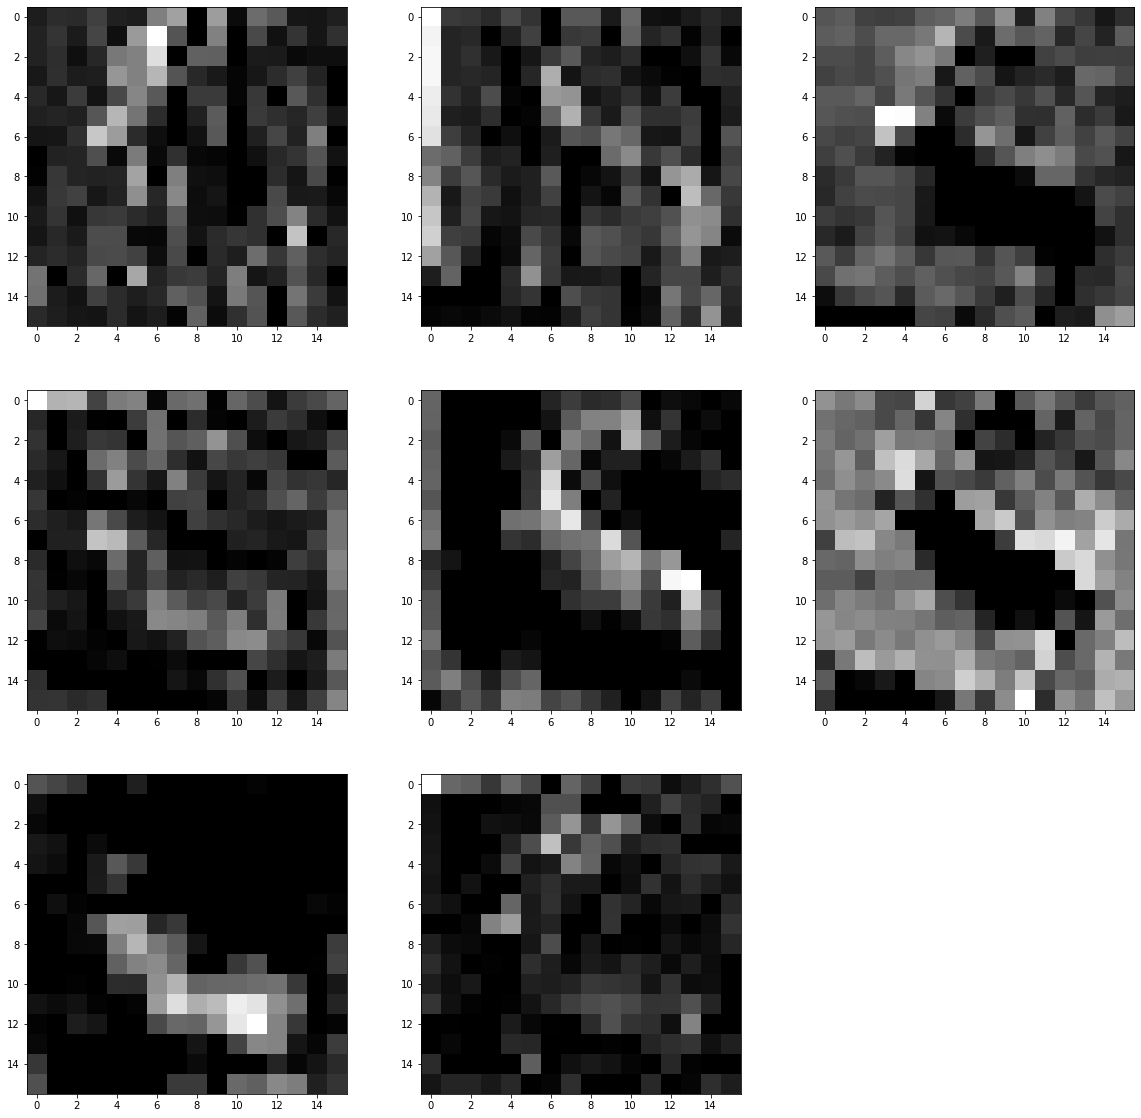

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


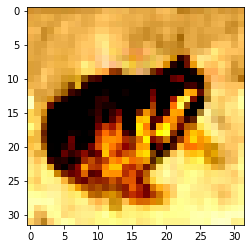

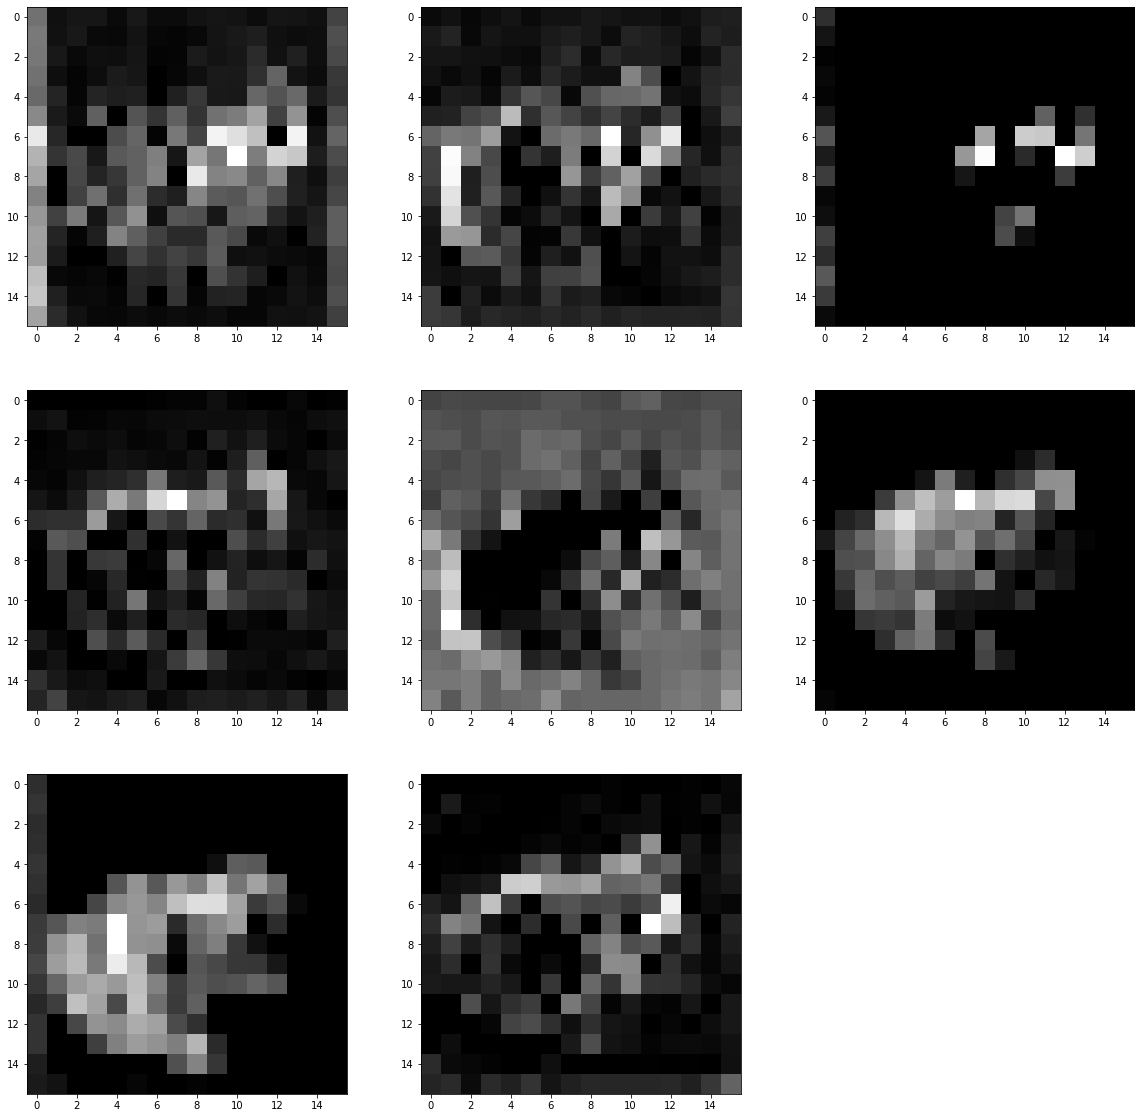

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


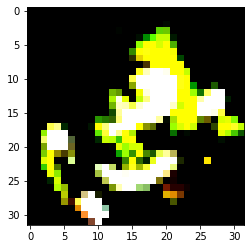

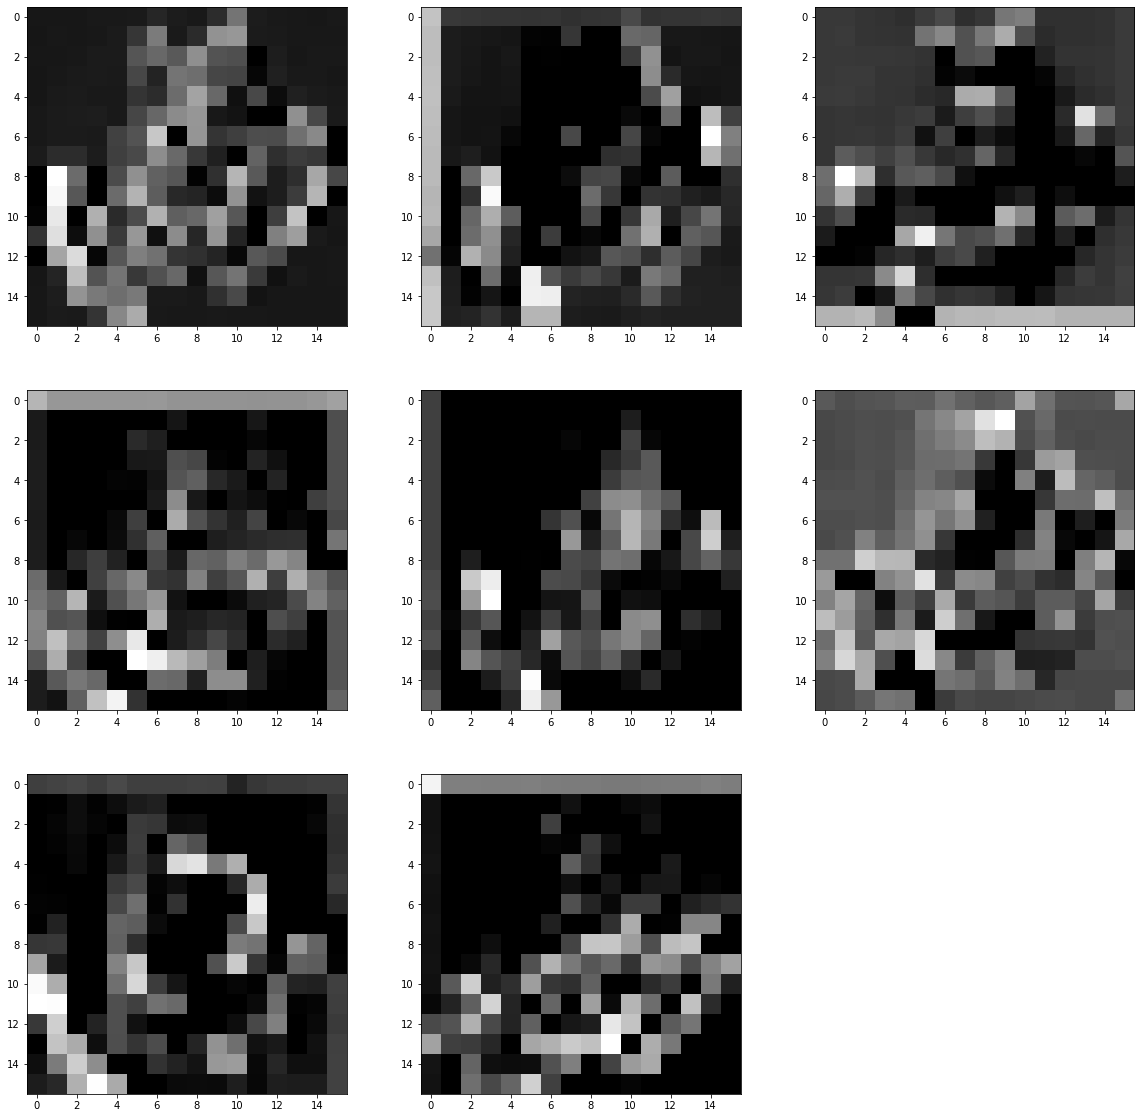

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


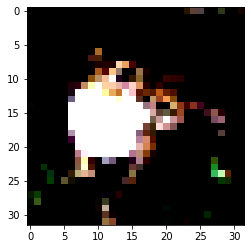

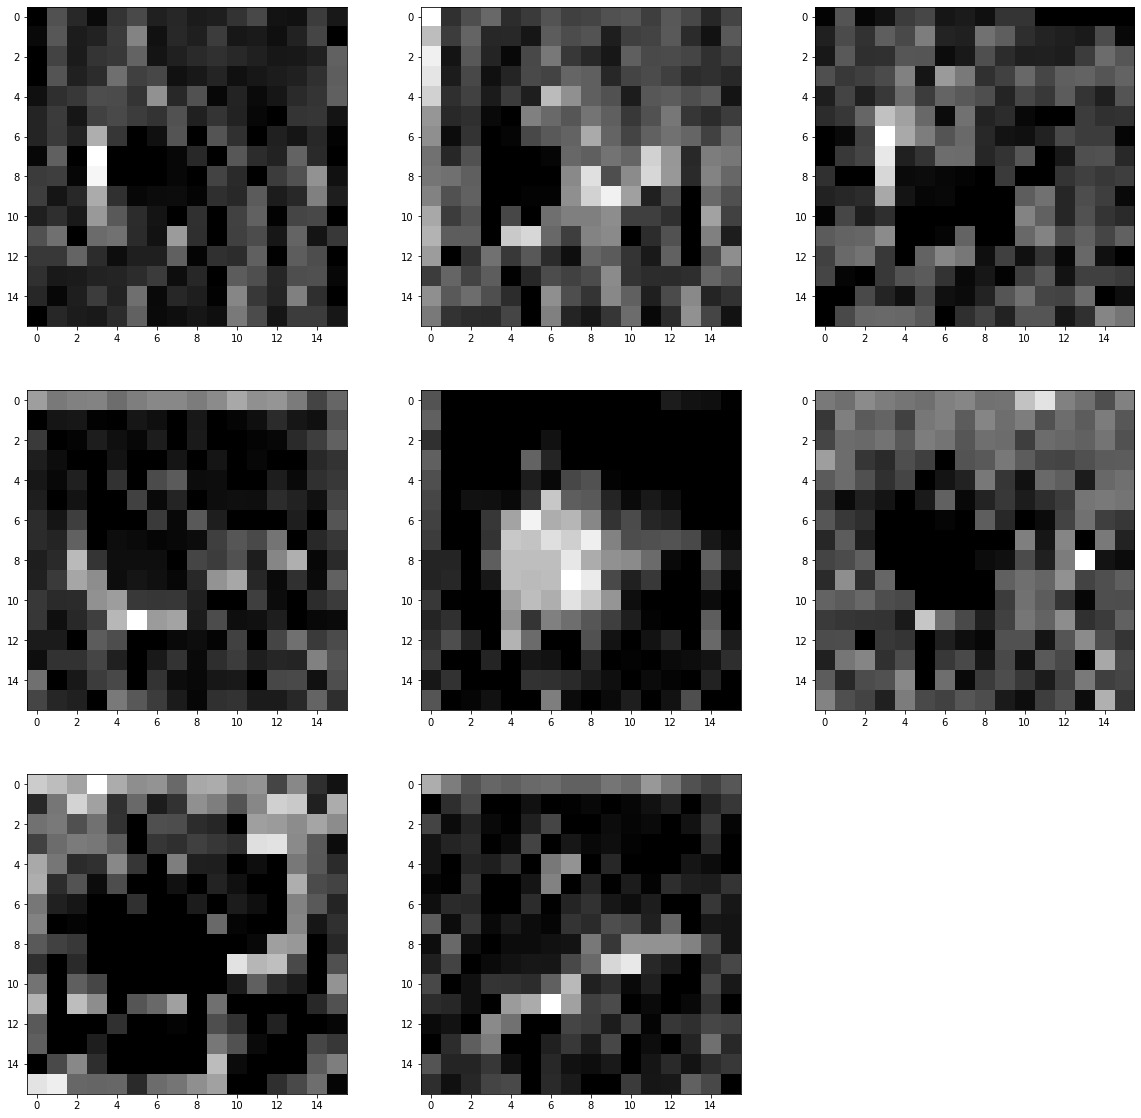

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


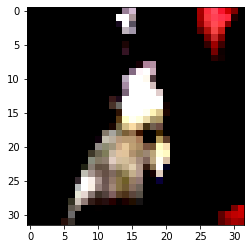

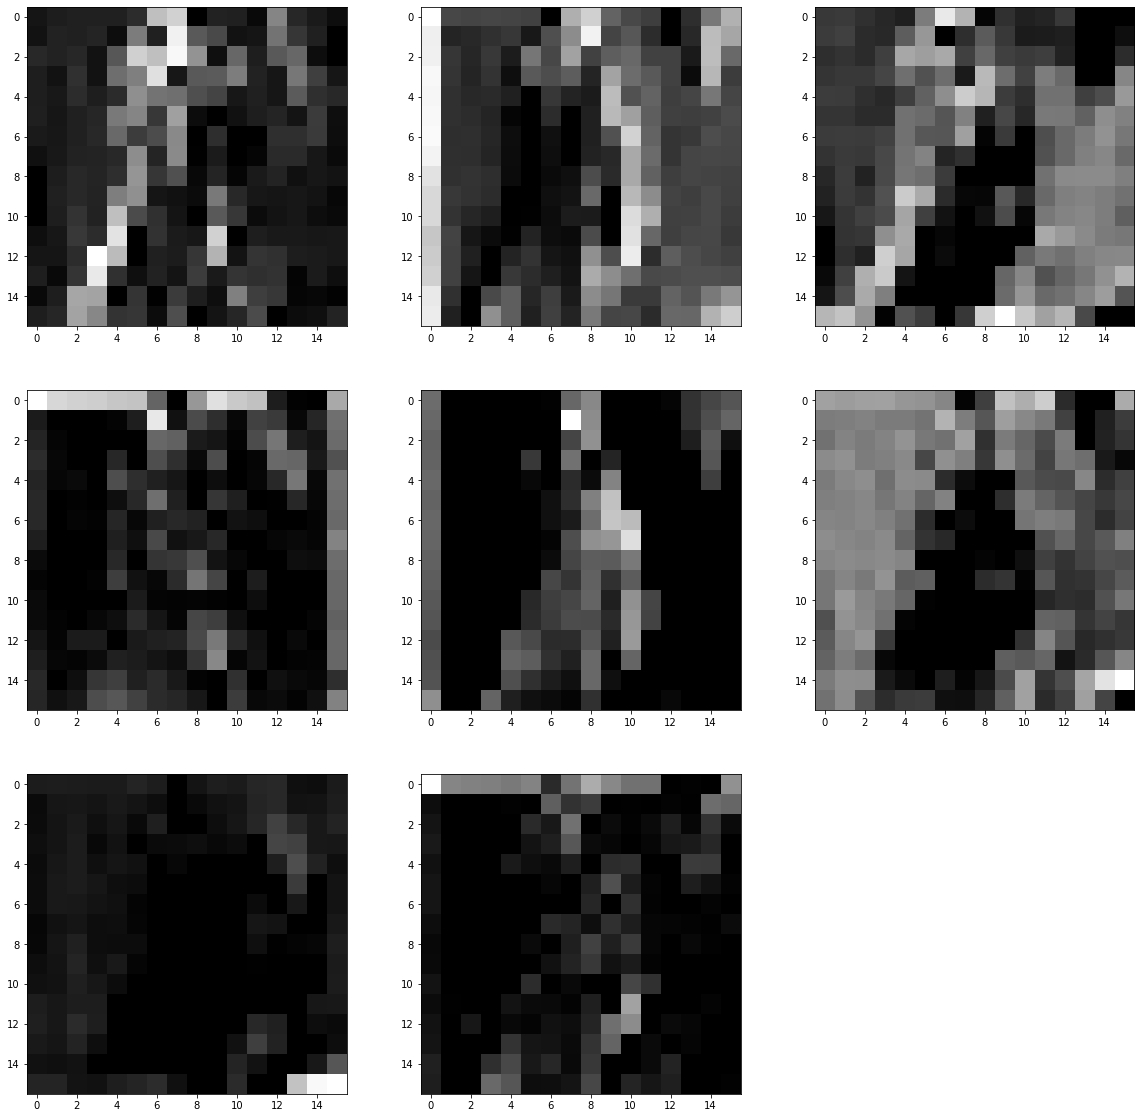

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


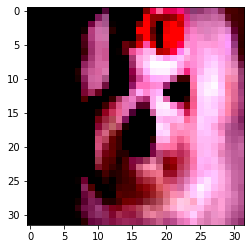

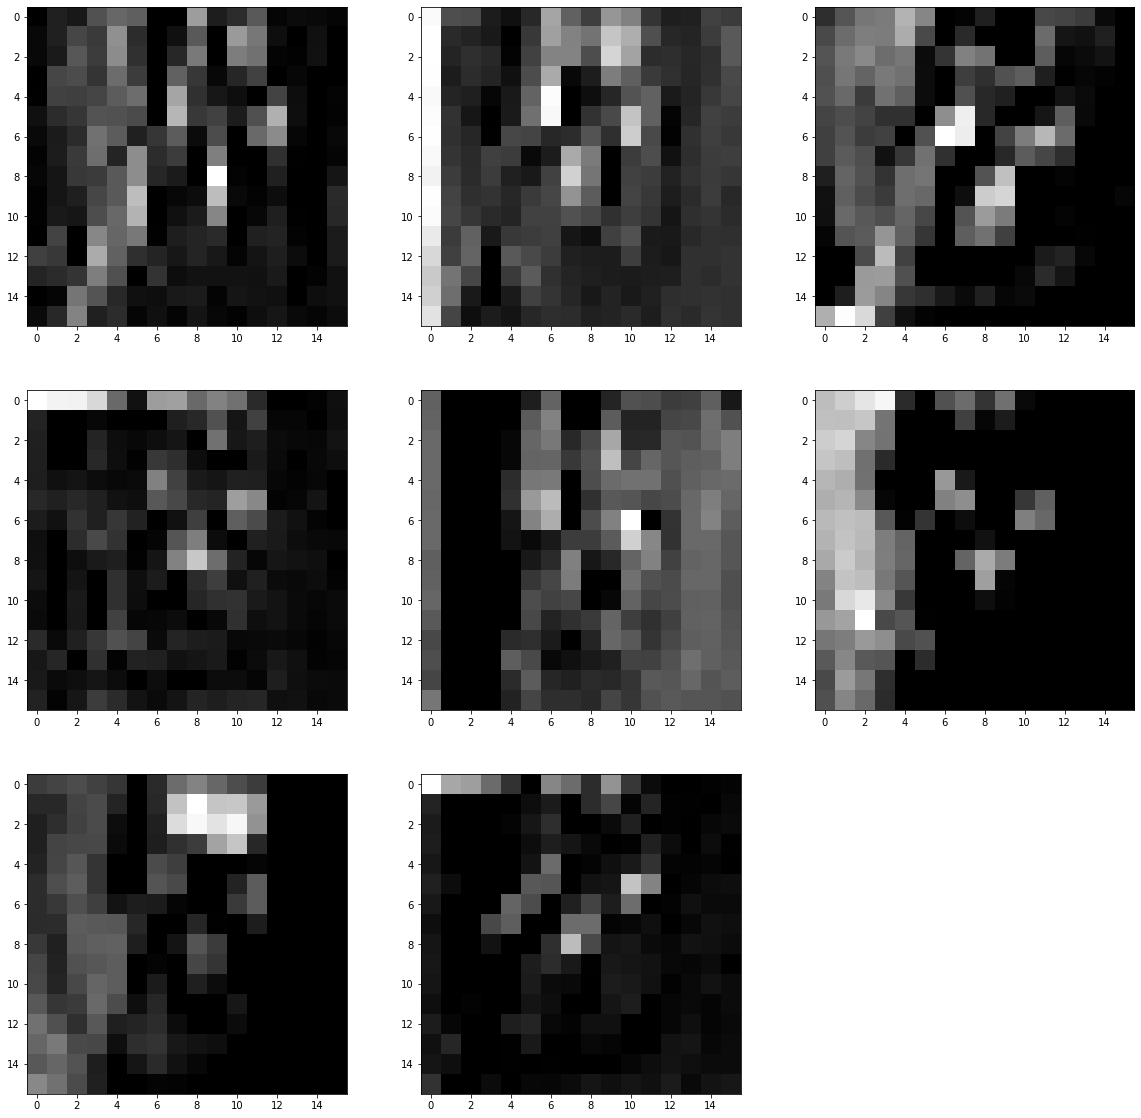

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


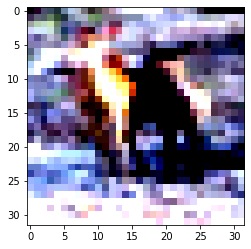

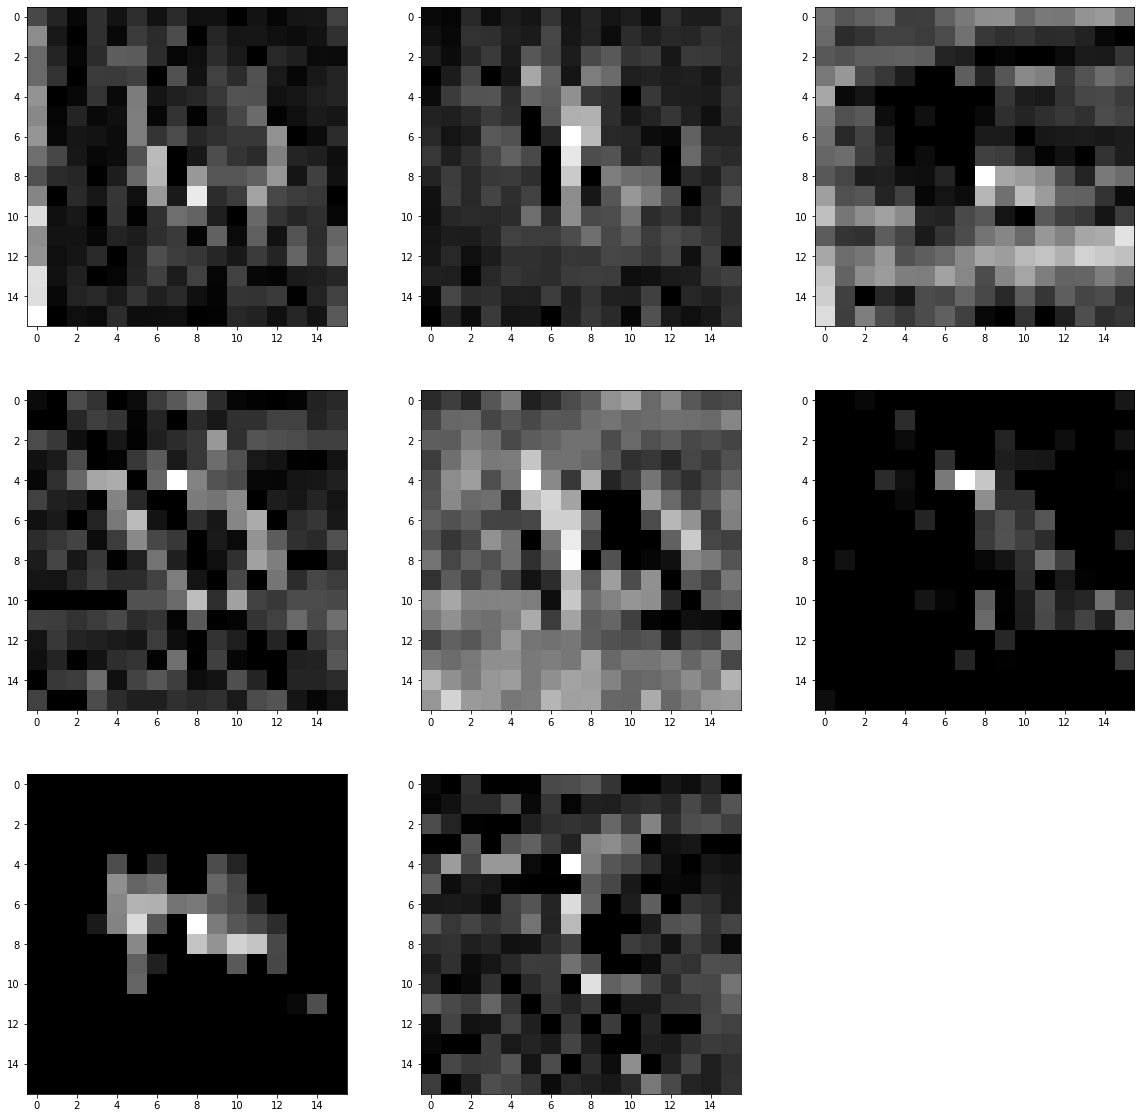

In [107]:
for k in FEATS.keys():
    if 'cnn1' in k:
        for n in range(10):
            plt.imshow(INPUTS[n].permute(1,2,0))
            plt.show()
            fig = plt.figure(figsize=(20, 20))
            for dim in range(FEATS[k].shape[1]):
                ax = plt.subplot("33{}".format(dim+1))
                ax.imshow(FEATS[k][n, dim, :], cmap='gray')
            plt.show()

## Compute distance

In [81]:
with open('checkpoints/CIFAR17_add010005-CIFAR10-model1/feat_representation.pkl', 'rb') as handle:
    FEATS = pickle.load(handle)

with open('checkpoints/CIFAR17_add010005-CIFAR10-model1/label.pkl', 'rb') as handle:
    LABELS = pickle.load(handle)

In [83]:
def Kernel_Mask(X, LABELS, method='linear'):
    '''
    Compute Distance with Labels
    :param X: shape N x p
    :param LABELS: gt labels shape N
    :param method: distance type
    '''
    
    if method == 'linear':
        # first standardize
        scaler = MinMaxScaler() # 0-1之间
        X = scaler.fit_transform(X) 
        L_X = cosine_similarity(X, X) # 越大离得越近
#         print(L_X.shape)
        
    elif method == 'rbf':
        # first standardize
        scaler = StandardScaler()
        X = scaler.fit_transform(X) 
        L_X = rbf_kernel(X, X) # 越大离得越近
#         print(L_X.shape)
        
    elif method == 'euclidean':
        # first standardize
        scaler = StandardScaler()
        X = scaler.fit_transform(X) 
        L_X = pairwise_distances(X, X, metric='euclidean')  # 越小离得越近
#         print(L_X.shape)
        
    else:
        raise NotImplementError
    
    # create mask for observations with same labels except for itself
    mask = ((LABELS[:,None] == LABELS).astype(float)) * (1-np.eye(L_X.shape[0])) 
    # create mask for observations with diff labels except for itself
    reverse_mask = ((LABELS[:,None] != LABELS).astype(float)) * (1-np.eye(L_X.shape[0])) 

    same_sum = np.dot(mask, L_X) * np.eye(L_X.shape[0]) # avg distance with same label
    diff_sum = np.dot(reverse_mask, L_X)  * np.eye(L_X.shape[0]) # avg distance with different label
    
    same_avg = np.diagonal(same_sum) / np.sum(mask, axis=0)
    diff_avg = np.diagonal(diff_sum) / np.sum(reverse_mask, axis=0)
    
    return L_X, same_avg, diff_avg

In [68]:
FEATS['cnn1'].shape 
# 1st dimension: number of observations,
# 2nd dimension: number of filters
# 3rd, 4th dimension: H, W

(10000, 9, 16, 16)

In [85]:
# flatten H, W dimensions
for k in FEATS.keys():
    FEATS[k] = FEATS[k].reshape(FEATS[k].shape[0], FEATS[k].shape[1], -1)

In [86]:
# get avg(avg(different labels distance) - avg(same labels distance))
for k in FEATS.keys():
    if 'cnn' in k:
        print(k)
        label_diff = []
        for dim in range(FEATS[k].shape[1]):
#             print('Feature {} Dim {}'.format(k, str(dim+1)))
            L_X, same_avg, diff_avg = Kernel_Mask(FEATS[k][:, dim, :], LABELS, method='euclidean')
            label_diff.append(np.mean(diff_avg - same_avg))

        print(np.mean(label_diff))

cnn1
(10000, 10000)
(10000, 10000)
(10000, 10000)
(10000, 10000)
(10000, 10000)
(10000, 10000)
(10000, 10000)
(10000, 10000)
(10000, 10000)
0.6409869505082465
cnn2
(10000, 10000)
(10000, 10000)
(10000, 10000)
(10000, 10000)
(10000, 10000)
(10000, 10000)
(10000, 10000)
(10000, 10000)
0.4671936293501406
cnn3
(10000, 10000)
(10000, 10000)
(10000, 10000)
(10000, 10000)
(10000, 10000)
(10000, 10000)
(10000, 10000)
(10000, 10000)
(10000, 10000)
(10000, 10000)
(10000, 10000)
(10000, 10000)
(10000, 10000)
0.31447663887077837
